# Setup


In [12]:
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import helperfunctions.preprocessing as hfprep
import helperfunctions.stationarity as hfstat
import helperfunctions.features as hffe

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel



# Load Datset from Huggingface



In [2]:
REPO_PATH = "hf://datasets/Creatorin/solarpower/"
splits = {'train': 'train_ts.csv', 'validation': 'val_ts.csv', 'test': 'test_ts.csv'}

# Load data
train_ts = pd.read_csv(REPO_PATH + splits["train"], index_col=0, date_format="%Y-%m-%d %H:%M:%S")
val_ts = pd.read_csv(REPO_PATH + splits["validation"], index_col=0, date_format="%Y-%m-%d %H:%M:%S")
test_ts = pd.read_csv(REPO_PATH + splits["test"], index_col=0, date_format="%Y-%m-%d %H:%M:%S")

# Make index datetime
train_ts.index = pd.to_datetime(train_ts.index)
val_ts.index = pd.to_datetime(val_ts.index)
test_ts.index = pd.to_datetime(test_ts.index)

# Copy train_ts to undo normalisation later
train_ts_copy = train_ts.copy()

# Verify Shapes
print(f"Train Shape: {train_ts.shape}, Validation Shape: {val_ts.shape}, Test Shape: {test_ts.shape}")

Train Shape: (70129, 31), Validation Shape: (8760, 31), Test Shape: (2926, 31)


# Preprocess Data
## Make Stationary

In [3]:
# Remove Trend and Seasonality
importlib.reload(hfstat)

# Make Unit Root Stationary
# train_ts = hfstat.make_stationary_unitroot(train_ts, val_ts, test_ts)

# Check variance stationarity
# hfstat.check_stationarity_variance(train_ts, 24)
# hfstat.check_stationarity_variance(train_ts, 365)
# # 
# # # Check target only 
# hfstat.check_stationarity_variance(train_ts["Leistung"], 24)
# hfstat.check_stationarity_variance(train_ts["Leistung"], 365)


<module 'helperfunctions.stationarity' from '/home/max/PycharmProjects/solar-prediction/helperfunctions/stationarity.py'>

In [4]:
# Detrend 
train_detrend = hfstat.detrend_ts(train_ts)
val_detrend = hfstat.detrend_ts(val_ts)
test_detrend = hfstat.detrend_ts(test_ts)

# Deseasonalise
train_deseasonal = hfstat.deseasonalise_ts(train_detrend, 365)
val_deseasonal = hfstat.deseasonalise_ts(val_detrend, 365)
test_deseasonal = hfstat.deseasonalise_ts(test_detrend, 365)

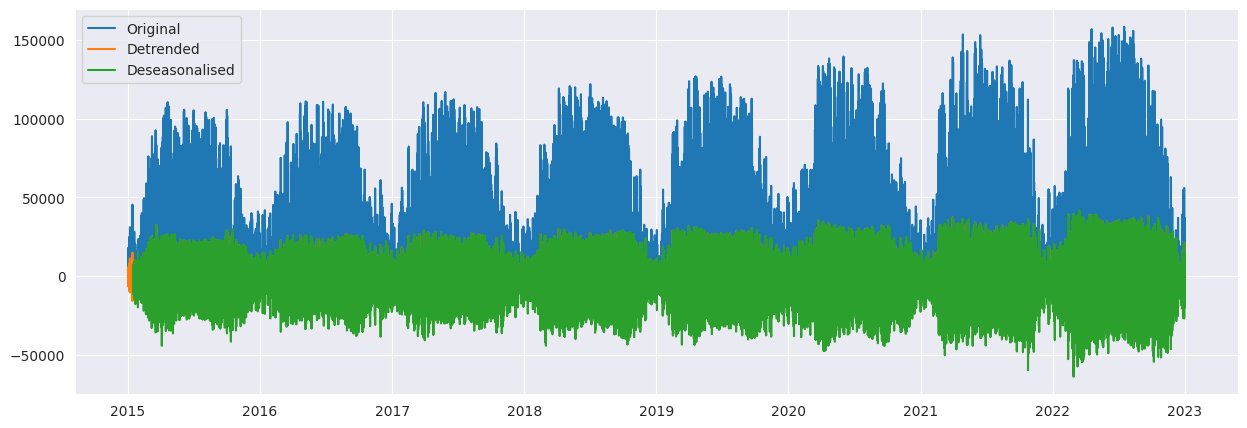

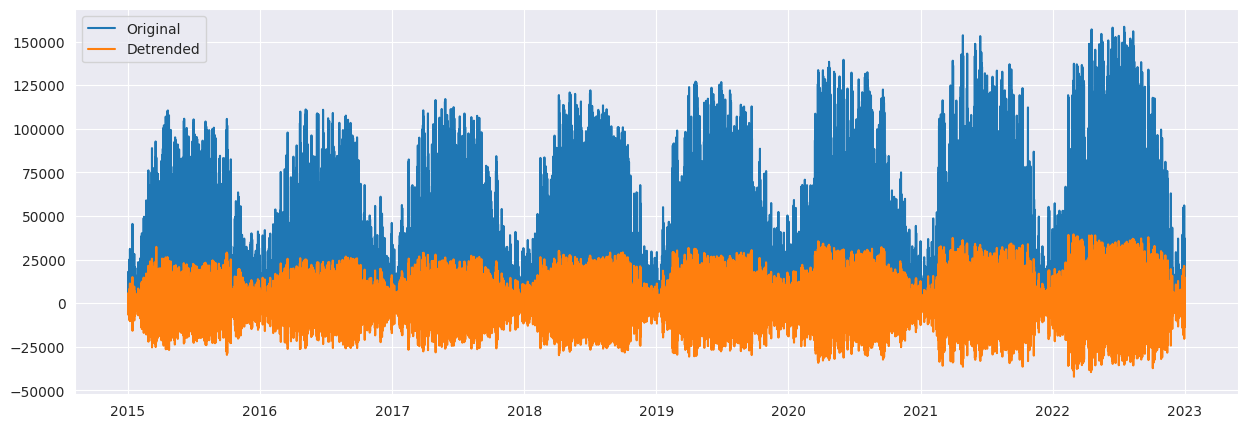

In [5]:
# Plot Leistung before and after
plt.figure(figsize=(15, 5))
plt.plot(train_ts["Leistung"], label="Original")
plt.plot(train_detrend["Leistung"], label="Detrended")
plt.plot(train_deseasonal["Leistung"], label="Deseasonalised")
plt.legend()
plt.show()

# Plot Leistung before and after
plt.figure(figsize=(15, 5))
plt.plot(train_ts["Leistung"], label="Original")
plt.plot(train_detrend["Leistung"], label="Detrended")
#plt.plot(train_deseasonal["Leistung"], label="Deseasonalised")
plt.legend()
plt.show()

# Feature Engineering


In [6]:
importlib.reload(hffe)

# Create Features
train_processed, val_processed, test_processed = hffe.create_lagged_features(train_deseasonal, val_deseasonal, test_deseasonal, lags=[1, 2, 3, 4, 5, 6, 12, 24, 48, 168, 365])
train_processed, val_processed, test_processed = hffe.create_rolling_features(train_processed, val_processed, test_processed, windows=[3, 6, 12, 24, 48, 168, 365])
train_processed, val_processed, test_processed = hffe.create_datetime_features(train_processed, val_processed, test_processed)

# Check the shape of the data
print(f"Train Shape: {train_processed.shape}, Validation Shape: {val_processed.shape}, Test Shape: {test_processed.shape}")
train_processed.head()

Train Shape: (69763, 5586), Validation Shape: (8394, 5586), Test Shape: (2560, 5586)


,Leistung,temperature_2m_templin,cloud_cover_templin,shortwave_radiation_templin,diffuse_radiation_templin,direct_normal_irradiance_templin,temperature_2m_kastellaun,cloud_cover_kastellaun,shortwave_radiation_kastellaun,diffuse_radiation_kastellaun,...,diffuse_radiation_neumunster_lag_365_rolling_mean_365,diffuse_radiation_neumunster_lag_365_rolling_std_365,direct_normal_irradiance_neumunster_lag_365_rolling_mean_365,direct_normal_irradiance_neumunster_lag_365_rolling_std_365,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,dayofyear_sin,dayofyear_cos
2015-01-16 05:00:00+00:00,0.0,-0.10,41.499999,0.0,0.0,0.000000,-5.000000e-02,-15.400000,0.0,0.0,...,NaN,NaN,NaN,NaN,0.965926,2.588190e-01,-0.433884,-0.900969,0.271234,0.962513
2015-01-16 06:00:00+00:00,0.0,0.15,27.600000,0.0,0.0,0.000000,-4.000000e-07,-0.299995,0.0,0.0,...,NaN,NaN,NaN,NaN,1.000000,6.123234e-17,-0.433884,-0.900969,0.271234,0.962513
2015-01-16 07:00:00+00:00,1251.4,0.05,25.500000,0.0,0.0,0.000000,-5.499996e-01,1.200005,0.0,0.0,...,NaN,NaN,NaN,NaN,0.965926,-2.588190e-01,-0.433884,-0.900969,0.271234,0.962513
2015-01-16 08:00:00+00:00,6186.5,0.55,17.100000,13.0,12.0,12.928265,1.500000e-01,3.600000,2.0,2.0,...,NaN,NaN,NaN,NaN,0.866025,-5.000000e-01,-0.433884,-0.900969,0.271234,0.962513
2015-01-16 09:00:00+00:00,7496.8,1.10,0.300003,72.0,36.0,265.371965,8.500000e-01,8.099995,18.0,18.0,...,NaN,NaN,NaN,NaN,0.707107,-7.071068e-01,-0.433884,-0.900969,0.271234,0.962513


In [7]:
train_processed.info()
train_processed.describe().transpose()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 69763 entries, 2015-01-16 05:00:00+00:00 to 2022-12-31 23:00:00+00:00
Columns: 5586 entries, Leistung to dayofyear_cos
dtypes: float64(5586)
memory usage: 2.9 GB


,count,mean,std,min,25%,50%,75%,max
Leistung,69763.0,-7.300676e-15,14129.504960,-63943.800000,-4303.450000,7.840000e+01,8491.000000,42174.400000
temperature_2m_templin,69763.0,1.963792e-04,1.185157,-11.500000,-0.700000,5.000000e-02,0.700000,9.700000
cloud_cover_templin,69763.0,1.820449e-04,25.788628,-174.700000,-11.199999,0.000000e+00,11.200000,146.700010
shortwave_radiation_templin,69763.0,0.000000e+00,97.693606,-770.000000,-21.000000,0.000000e+00,53.000000,521.000000
diffuse_radiation_templin,69763.0,0.000000e+00,40.718875,-337.000000,-12.000000,0.000000e+00,24.000000,236.000000
...,...,...,...,...,...,...,...,...
hour_cos,69763.0,-5.789685e-05,0.707102,-1.000000,-0.707107,-1.836970e-16,0.707107,1.000000
dayofweek_sin,69763.0,-4.535651e-04,0.707161,-0.974928,-0.781831,0.000000e+00,0.781831,0.974928
dayofweek_cos,69763.0,-3.219316e-04,0.707062,-0.900969,-0.900969,-2.225209e-01,0.623490,1.000000
dayofyear_sin,69763.0,-7.239782e-04,0.709595,-0.999963,-0.710135,-1.716633e-02,0.710135,0.999963


In [8]:
# Check missing 
train_processed.isnull().sum()

Leistung                       0
temperature_2m_templin         0
cloud_cover_templin            0
shortwave_radiation_templin    0
diffuse_radiation_templin      0
                              ..
hour_cos                       0
dayofweek_sin                  0
dayofweek_cos                  0
dayofyear_sin                  0
dayofyear_cos                  0
Length: 5586, dtype: int64

# Standardise Data

In [9]:
# Normalise the data
train_processed, val_processed, test_processed = hfprep.normalise_ts(train_processed, val_processed, test_processed)

# Check the normalised data mean and std
print(f"Train Mean: {train_processed.mean()}, Train Std: {train_processed.std()}")

Train Mean: Leistung                       3.055528e-19
temperature_2m_templin         2.016649e-17
cloud_cover_templin            1.764568e-17
shortwave_radiation_templin    1.069435e-18
diffuse_radiation_templin     -4.067672e-18
                                   ...     
hour_cos                      -7.231417e-18
dayofweek_sin                 -1.049065e-17
dayofweek_cos                 -5.133288e-17
dayofyear_sin                 -1.955538e-17
dayofyear_cos                  6.518460e-18
Length: 5586, dtype: float64, Train Std: Leistung                       1.0
temperature_2m_templin         1.0
cloud_cover_templin            1.0
shortwave_radiation_templin    1.0
diffuse_radiation_templin      1.0
                              ... 
hour_cos                       1.0
dayofweek_sin                  1.0
dayofweek_cos                  1.0
dayofyear_sin                  1.0
dayofyear_cos                  1.0
Length: 5586, dtype: float64


# Remove first year of data


In [14]:
# Remove first year of data
train_processed = train_processed["2016-01-01":]

# Feature Selection



In [ ]:
# Random Forest Feature selection 
def select_features_randomforest(train_data, train_target, n_features=30):
    estimator = RandomForestRegressor()
    selector = SelectFromModel(estimator, max_features=n_features)
    selector = selector.fit(train_data, train_target)

    # Get the boolean mask of selected features
    selected_feature_indices = selector.get_support()

    # Filter the columns using the mask
    slctd_features = train_data.columns[selected_feature_indices]

    return train_data[slctd_features], slctd_features

# Select features
train_processed, selected_features = select_features_randomforest(train_processed, train_processed['Leistung'], n_features=50)
print(f"Selected Features: {selected_features}")

In [11]:
# PCA
from sklearn.decomposition import PCA

# Fit PCA
pca = PCA(n_components=0.95)
pca.fit(train_processed)

# Transform data
train_pca = pca.transform(train_processed)
val_pca = pca.transform(val_processed)
test_pca = pca.transform(test_processed)

# Check the shape of the data
print(f"Train Shape: {train_pca.shape}, Validation Shape: {val_pca.shape}, Test Shape: {test_pca.shape}")

# Plot explained variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.show()

ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

# Save Data


In [ ]:
# Save to CSV with datetime index
# train_processed.to_csv("data/train_processed.csv", header=True, index=True, index_label=False)
# val_processed.to_csv("data/val_processed.csv", header=True, index=True, index_label=False)
# test_processed.to_csv("data/test_processed.csv", header=True, index=True, index_label=False)

In [ ]:
# Create sequences
def create_sequences(series: pd.Series, target_column: str, sequence_length: int = 24, batch_size: int = 8) -> (np.ndarray, np.ndarray):
    features = series.values
    target = series[target_column].values
    
    data_gen = TimeseriesGenerator(
        features, 
        target, 
        sequence_length, 
        batch_size
    )
    
    X, y = [], []
    for i in range(len(data_gen)):
        x, y_batch = data_gen[i]
        X.append(x)
        y.append(y_batch)
        
    X = np.concatenate(X)
    y = np.concatenate(y)
        
    return X, y


# Create sequences
sequence_length = 24
batch_size = 8
target_column = 'Leistung'

X_train, y_train = create_sequences(train_processed, target_column, sequence_length, batch_size)
X_val, y_val = create_sequences(val_processed, target_column, sequence_length, batch_size)
X_test, y_test = create_sequences(test_processed, target_column, sequence_length, batch_size)


# Print the shapes
print("Training set - X shape:", X_train.shape, "y shape:", y_train.shape)
print("Validation set - X shape:", X_val.shape, "y shape:", y_val.shape)
print("Test set - X shape:", X_test.shape, "y shape:", y_test.shape)

# LSTM model

def create_lstm_model(input_shape, units=50, dropout_rate=0.2, learning_rate=0.0001, loss='mse'):
    model = Sequential([
        LSTM(units, return_sequences=True, input_shape=input_shape),
        Dropout(dropout_rate),
        LSTM(units),
        Dropout(dropout_rate),
        Dense(1)
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    
    return model

def train_lstm_model(model, X_train, y_train, X_val, y_val, epochs=10, batch_size=8):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    # model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks= early_stopping, #[early_stopping, model_checkpoint],
        verbose=1
    )
    
    return history

# Create the model
input_shape = (X_train.shape[1], X_train.shape[2])
model = create_lstm_model(input_shape)

# Train the model
history = train_lstm_model(model, X_train, y_train, X_val, y_val)

# Evaluate the model
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}")

# Make predictions
predictions = model.predict(X_test)


# Plot train val losses
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot predictions 
plt.plot(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

# calculate performance metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, root_mean_squared_error

def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    return mae, mse, rmse, r2, mape

mae, mse, rmse, r2, mape = calculate_metrics(y_test, predictions)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R^2 Score: {r2}")
print(f"Mean Absolute Percentage Error: {mape}")

In [ ]:
# Feature Importance
def permutation_importance(model, X, y, n_repeats=10):
    baseline_mse = mean_squared_error(y, model.predict(X))
    importances = []
    
    for column in range(X.shape[2]):  # Iterate over features
        feature_importances = []
        for _ in range(n_repeats):
            X_permuted = X.copy()
            X_permuted[:,:,column] = np.random.permutation(X_permuted[:,:,column])
            permuted_mse = mean_squared_error(y, model.predict(X_permuted))
            importance = permuted_mse - baseline_mse
            feature_importances.append(importance)
        importances.append(np.mean(feature_importances))
    
    return importances

# Calculate permutation importance
importances = permutation_importance(model, X_test, y_test)

# get feature names (column names)
feature_names = train_processed.columns

# Create a DataFrame for easier plotting
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance (Increase in MSE)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print feature importance
print(importance_df)

In [ ]:
# print feature names importance
importance_df.describe().transpose()